<a href="https://colab.research.google.com/github/Gio1709/paddy_100m/blob/master/New_Identifikasi_Lahan_Pertanian_100m_dan_Perbandingannya_VGG16_Fix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **IDENTIFIKASI VEGETASI OTOMATIS DENGAN GAMBAR GOOGLE EARTH MENGGUNAKAN CONVOLUTIONAL NEURAL NETWORK**

# Preferensi

Penelitian Sebelumnya :
**Metode Convolutional Neural Network pada Gambar Google Earth Hutan Bambu di Jepang dengan .** 

*Shuntaro Watanabe, Kazuaki Sumi, Takeshi Ise*

link sebagai berikut : https://doi.org/10.1101/351643

**Note**

Penelitian ini mengambil konsep dari peneliti asal Jepang yang mengidentifikasikan vegatasi akurasi tinggi lahan hutan bamboo di beberapa wilayah Jepang, dengan klasisfikasi CNN, dan dilakukan dengan metode chopped-image.

Sedangkan pada penelitian ini memiliki konsep yang serupa dengan penelitian sebelumnya, akan tetapi mengambil sampel yang dilakukan lahan persawahan di Kabupaten Banyumas. 

Peneliti : Fendy Prayogi

Repositori tersedia pada : https://github.com/Gio1709/paddy


# Mengimpor/Mengambil Fungsi Library

In [1]:
!pip install slidingwindow
import slidingwindow as sw
import numpy as np
import os
import keras.backend as K
import keras
import pandas as pd
from keras.models import Sequential
from keras import layers
from keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
from skimage.io import imread, imsave
from skimage.transform import resize
from sklearn.utils.class_weight import compute_class_weight

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels



Using TensorFlow backend.


# Mengambil Dataset dari Github

In [0]:
# Mengambil dataset dari github

#!apt-get install subversion > /dev/null
#!svn export https://github.com/Gio1709/paddy/trunk/data > /dev/null 

#!apt-get install subversion > /dev/null
#!svn export https://github.com/Gio1709/paddy_100/trunk/data > /dev/null 

#!apt-get install subversion > /dev/null
#!svn export https://github.com/Gio1709/paddy_300/trunk/data > /dev/null 

#!apt-get install subversion > /dev/null
#!svn export https://github.com/Gio1709/paddy-coba/trunk/data/ > /dev/null 

#!apt-get install subversion > /dev/null
#!svn export https://github.com/Gio1709/paddy_100m_new/trunk/data/ > /dev/null 

!apt-get install subversion > /dev/null
!svn export https://github.com/Gio1709/paddy_100m/trunk/data/ > /dev/null 

#!apt-get install subversion > /dev/null
#!svn export https://github.com/Gio1709/paddy_300m/trunk/data/ > /dev/null 

#!apt-get install subversion > /dev/null
#!svn export https://github.com/Gio1709/paddy_300m_new/trunk/data/ > /dev/null 

#!wget https://raw.githubusercontent.com/Gio1709/paddy/master/paddy.zip paddy.zip
#!unzip -P paddy paddy.zip


**Persiapan :**

*Program ini dibuat untuk mengidentifikasi lahan sawah dan luas di Kabupaten Banyumas*

File tersimpan dalam folder :
1. */chopped*
2. */train*
3. */test* 

# Mengimpor Datasheet

In [3]:
#Perintah untuk melihat list bagian dari file yang sudah diunduh dari Github

!ls data/paddy/train
#gambar dengan nama awalan dengan "b" adalah gambar yang terdapat padi"
#gambar dengan nama awalan dengan "o" adalah gambar yang tidak terdapat padi"

b100.jpg  b119.jpg  b63.jpg  b82.jpg   o101.jpg  o120.jpg  o64.jpg  o83.jpg
b101.jpg  b120.jpg  b64.jpg  b83.jpg   o102.jpg  o121.jpg  o65.jpg  o84.jpg
b102.jpg  b121.jpg  b65.jpg  b84.jpg   o103.jpg  o122.jpg  o66.jpg  o85.jpg
b103.jpg  b122.jpg  b66.jpg  b85.jpg   o104.jpg  o123.jpg  o67.jpg  o86.jpg
b104.jpg  b123.jpg  b67.jpg  b86.jpg   o105.jpg  o124.jpg  o68.jpg  o87.jpg
b105.jpg  b124.jpg  b68.jpg  b87.jpg   o106.jpg  o125.jpg  o69.jpg  o88.jpg
b106.jpg  b125.jpg  b69.jpg  b88.jpg   o107.jpg  o51.jpg   o70.jpg  o89.jpg
b107.jpg  b51.jpg   b70.jpg  b89.jpg   o108.jpg  o52.jpg   o71.jpg  o90.jpg
b108.jpg  b52.jpg   b71.jpg  b90.jpg   o109.jpg  o53.jpg   o72.jpg  o91.jpg
b109.jpg  b53.jpg   b72.jpg  b91.jpg   o110.jpg  o54.jpg   o73.jpg  o92.jpg
b110.jpg  b54.jpg   b73.jpg  b92.jpg   o111.jpg  o55.jpg   o74.jpg  o93.jpg
b111.jpg  b55.jpg   b74.jpg  b93.jpg   o112.jpg  o56.jpg   o75.jpg  o94.jpg
b112.jpg  b56.jpg   b75.jpg  b94.jpg   o113.jpg  o57.jpg   o76.jpg  o95.jpg
b113.jpg  b5

#Menampilkan Gambar Pelatihan

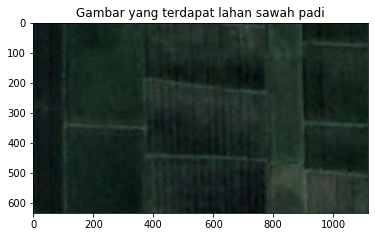

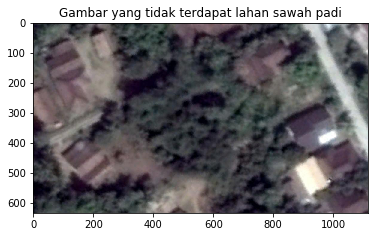

In [4]:
#Gambar yang terdapat lahan sawah padi
plt.title("Gambar yang terdapat lahan sawah padi")
plt.imshow(imread("data/paddy/train/b58.jpg"))
plt.show()

#Gambar yang terdapat tidak lahan sawah padi
plt.title("Gambar yang tidak terdapat lahan sawah padi")
plt.imshow(imread("data/paddy/train/o125.jpg"))
plt.show()


# Membuat "patches" dari setiap gambar menggunakan metode sliding window

**Apa itu *Sliding Window* ?**

*Sliding window* adalah window yang bergeser untuk memprediksi dan mencari area objek yang benar. Suatu proses deteksi objek memerlukan teknik lokalisasi 
untuk menemukan area objek. 



In [0]:
def save_to_folder(img_path,directory,size=56,overlap=0.4):
    #Membaca gambar path penyimpanan window ke direktori/file yang spesifik
    img = imread(img_path)
    basename = os.path.basename(img_path)
    fname = os.path.splitext(basename)[0]
    windows = sw.generate(img, sw.DimOrder.HeightWidthChannel, size, overlap)
    for i,window in enumerate(windows):
        ii = str("{0:05d}".format(i))
        _fname = fname + "_" + ii + ".jpg"
        _img = img[window.indices()]
        if _img.shape !=(size,size,3):
            continue
        img_target_path = os.path.join(directory,_fname)
        
        imsave(img_target_path,_img, check_contrast=False)

files = os.listdir("data/paddy/train/")
files = [x for x in files if x.endswith(".jpg")]

#Menyimpan gambar yang telah dicacah pada folder chopped
for file in files:
    save_directory = "data/paddy/chopped/"
    file = os.path.join("data/paddy/train/",file)
    save_to_folder(file,save_directory)

# Dataset Pelatihan dari 3 Pulau Berbeda
Terdapat 3 dataset yang digunakan dalam Model Performa Klasifikasi akurasi, Recall Rate dan Presisi. Data pelatihan yang telah dichop sehingga menghasilkan gambar baru, lalu kita klasifikasikan hasilnya dengan empat kategori berupa :  *true positive* (TP), *false positive* (FP), *false negative* (FN), dan *true negative* (TN). 
Dengan ketentuan prediksi benar atau salah dan gambar sawah atau bukan sawah. Pada Gambar Sawah dilabeli dengan nama huruf "b" dan ada gambar bukan sawah dilabeli dengan nama huruf "o".

In [6]:
#Mengembalikan daftar gambar yang telah diacak pada direktori
#Data yang dilakukan pada model evaluasi

#Dataset Pulau Jawa
files = os.listdir("data/paddy/chopped/")
files = [x for x in files if x.endswith(".jpg")]

#Memuat dataset Pelatihan
x = []
y = []

for file in files:
    if file.startswith("b"):
        label = 1
    else:
        label = 0
    
    img_path = os.path.join("data/paddy/chopped/",file)
    img = load_img(img_path)
    img = img_to_array(img)/255
    x.append(img)
    y.append(label)

X = np.array(x)
Y = np.array(y)
print("Bentuk array dari dataset train (pelatihan) adalah :", (X.shape,Y.shape))

Bentuk array dari dataset train (pelatihan) adalah : ((89100, 56, 56, 3), (89100,))


**Pulau Jawa**

In [7]:
files = os.listdir("data/paddy/test/Jawa")
files = [x for x in files if x.endswith(".jpg")]

#Memuat dataset pengujian

X_test1 = []
Y_test1 = []

for file in files:
    if file.startswith("b"):
        label1 = 1
    else:
        label1 = 0
    
    img_path1 = os.path.join("data/paddy/test/Jawa",file)
    img1 = load_img(img_path1)
    img1 = img_to_array(img1)/255.
    img1 = resize(img1,(56,56))
    X_test1.append(img1)
    Y_test1.append(label1)

x_test1 = np.array(X_test1)
y_test1 = np.array(Y_test1)
print("Bentuk array dari dataset test pulau Jawa (pengujian) adalah :", (x_test1.shape,y_test1.shape))

files= pd.Index(files)
print("Tampilan list gambar yang telah dichop :\n",files.value_counts())

Bentuk array dari dataset test pulau Jawa (pengujian) adalah : ((20, 56, 56, 3), (20,))
Tampilan list gambar yang telah dichop :
 o153.jpg    1
b160.jpg    1
b155.jpg    1
b158.jpg    1
o152.jpg    1
o159.jpg    1
o155.jpg    1
o154.jpg    1
b151.jpg    1
b159.jpg    1
o151.jpg    1
o156.jpg    1
b152.jpg    1
o160.jpg    1
o158.jpg    1
b153.jpg    1
b154.jpg    1
o157.jpg    1
b156.jpg    1
b157.jpg    1
dtype: int64


**Pulau Kalimantan**

In [8]:
files = os.listdir("data/paddy/test/Kalimantan")
files = [x for x in files if x.endswith(".jpg")]

#Memuat dataset pengujian

X_test2 = []
Y_test2 = []

for file in files:
    if file.startswith("b"):
        label2 = 1
    else:
        label2 = 0
    
    img_path2 = os.path.join("data/paddy/test/Kalimantan",file)
    img2 = load_img(img_path2)
    img2 = img_to_array(img2)/255.
    img2 = resize(img2,(56,56))
    X_test2.append(img2)
    Y_test2.append(label2)

x_test2 = np.array(X_test2)
y_test2 = np.array(Y_test2)
print("Bentuk array dari dataset test pulau Kalimantan (pengujian) adalah :", (x_test2.shape,y_test2.shape))

files= pd.Index(files)
print("Tampilan list gambar yang telah dichop :\n",files.value_counts())

Bentuk array dari dataset test pulau Kalimantan (pengujian) adalah : ((20, 56, 56, 3), (20,))
Tampilan list gambar yang telah dichop :
 o164.jpg    1
o162.jpg    1
o165.jpg    1
o169.jpg    1
b164.jpg    1
b167.jpg    1
b162.jpg    1
o166.jpg    1
b161.jpg    1
o163.jpg    1
b166.jpg    1
o170.jpg    1
b165.jpg    1
b169.jpg    1
o167.jpg    1
b170.jpg    1
o168.jpg    1
b168.jpg    1
b163.jpg    1
o161.jpg    1
dtype: int64


**Pulau Sumatra**

In [9]:
files = os.listdir("data/paddy/test/Sumatra")
files = [x for x in files if x.endswith(".jpg")]

#Memuat dataset pengujian

X_test3 = []
Y_test3 = []

for file in files:
    if file.startswith("b"):
        label3 = 1
    else:
        label3 = 0
    
    img_path3 = os.path.join("data/paddy/test/Sumatra",file)
    img3 = load_img(img_path3)
    img3 = img_to_array(img3)/255.
    img3 = resize(img3,(56,56))
    X_test3.append(img3)
    Y_test3.append(label3)

x_test3 = np.array(X_test3)
y_test3 = np.array(Y_test3)
print("Bentuk array dari dataset test pulau Sumatra (pengujian) adalah :", (x_test3.shape,y_test3.shape))

files= pd.Index(files)
print("Tampilan list gambar yang telah dichop :\n",files.value_counts())

Bentuk array dari dataset test pulau Sumatra (pengujian) adalah : ((20, 56, 56, 3), (20,))
Tampilan list gambar yang telah dichop :
 b171.jpg    1
o179.jpg    1
170.jpg     1
b180.jpg    1
o171.jpg    1
b179.jpg    1
b177.jpg    1
b178.jpg    1
b173.jpg    1
b174.jpg    1
b172.jpg    1
o176.jpg    1
o173.jpg    1
o174.jpg    1
o172.jpg    1
o175.jpg    1
b175.jpg    1
b176.jpg    1
o178.jpg    1
o177.jpg    1
dtype: int64


In [10]:
from sklearn.model_selection import train_test_split

train_x, valid_x, train_y, valid_y = train_test_split(X,Y,test_size=0.25,stratify = y)

print("Bentuk array dari dataset train (pelatihan) adalah:",train_x.shape,train_y.shape)
print("Bentuk array dari dataset validation adalah:",valid_x.shape,valid_y.shape)
#print("Bentuk array dari dataset test (pengujian) adalah:",x_test.shape,y_test.shape)

Bentuk array dari dataset train (pelatihan) adalah: (66825, 56, 56, 3) (66825,)
Bentuk array dari dataset validation adalah: (22275, 56, 56, 3) (22275,)


In [11]:
#Mengkomputasi kelas bobotnya
print(np.unique(train_y,return_counts=True))
print(np.unique(valid_y,return_counts=True))

cw = compute_class_weight("balanced",np.unique(train_y),train_y)
print(cw)

(array([0, 1]), array([33412, 33413]))
(array([0, 1]), array([11138, 11137]))
[1.00001496 0.99998504]


#Pembuatan Model

In [0]:
import tensorflow as tf
from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix
import pandas as pd

In [0]:
IMG_SHAPE = (56, 56, 3)
# Membuat model dasar (base model) dari pre-trained model MobileNet
base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                              include_top=False, 
                                              weights='imagenet')

In [83]:
base_model.trainable = False
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 56, 56, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 56, 56, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 56, 56, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 28, 28, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 28, 28, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 28, 28, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 14, 14, 128)       0     

In [86]:
model = tf.keras.Sequential([
    base_model,  
    #tf.keras.layers.Conv2D(64,(3,3),name="conv1",input_shape=(56,56,3),activation="relu",padding="same"),   
    #tf.keras.layers.MaxPool2D((2,2),name="pool1"),
    #tf.keras.layers.Dropout(0.5),
    #tf.keras.layers.Conv2D(64,(3,3),name="conv2",padding="same"),
    #tf.keras.layers.Activation("relu"),
    #tf.keras.layers.MaxPool2D((2,2),name="pool2"),
    #tf.keras.layers.Dropout(0.5),
    #tf.keras.layers.Conv2D(32,(3,3),name="conv3",padding="same"),
    #tf.keras.layers.Activation("relu"),
    #tf.keras.layers.MaxPool2D((2,2),name="pool3"),
    #tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64,activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1), 
    tf.keras.layers.Activation("sigmoid",name="prediction")
]
)

model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["acc"])

model.summary()

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_29 (Flatten)         (None, 512)               0         
_________________________________________________________________
dense_55 (Dense)             (None, 64)                32832     
_________________________________________________________________
dropout_35 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_56 (Dense)             (None, 1)                 65        
_________________________________________________________________
prediction (Activation)      (None, 1)                 0         
Total params: 14,747,585
Trainable params: 32,897
Non-trainable params: 14,714,688
____________________________________

In [87]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

#Menyimpan model bobot yang terbaik selama training
ckpt = ModelCheckpoint("paddy.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

history = model.fit(train_x,train_y,batch_size=200,epochs=50,validation_data=(valid_x,valid_y),class_weight=cw, callbacks = [ckpt])

Train on 66825 samples, validate on 22275 samples
Epoch 1/50
66800/66825 [============================>.] - ETA: 0s - loss: 0.3011 - acc: 0.8831
Epoch 00001: val_loss improved from inf to 0.18192, saving model to paddy.h5
66825/66825 [==============================] - 54s 810us/sample - loss: 0.3012 - acc: 0.8830 - val_loss: 0.1819 - val_acc: 0.9347
Epoch 2/50
66800/66825 [============================>.] - ETA: 0s - loss: 0.1777 - acc: 0.9370
Epoch 00002: val_loss improved from 0.18192 to 0.15869, saving model to paddy.h5
66825/66825 [==============================] - 21s 310us/sample - loss: 0.1777 - acc: 0.9370 - val_loss: 0.1587 - val_acc: 0.9459
Epoch 3/50
66600/66825 [============================>.] - ETA: 0s - loss: 0.1502 - acc: 0.9480
Epoch 00003: val_loss improved from 0.15869 to 0.12727, saving model to paddy.h5
66825/66825 [==============================] - 21s 313us/sample - loss: 0.1500 - acc: 0.9481 - val_loss: 0.1273 - val_acc: 0.9510
Epoch 4/50
66600/66825 [============

#Menggambarkan Hasil Pelatihan

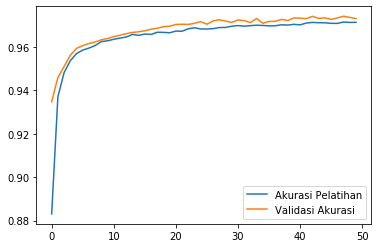

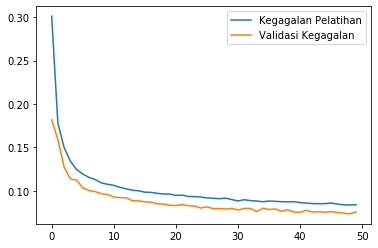

In [88]:
plt.plot(history.history["acc"],label="Akurasi Pelatihan")
plt.plot(history.history["val_acc"],label="Validasi Akurasi")
plt.legend()
plt.show()

plt.plot(history.history["loss"],label="Kegagalan Pelatihan")
plt.plot(history.history["val_loss"],label="Validasi Kegagalan")
plt.legend()
plt.show()

# Evaluasi dengan model


In [89]:
#Memeriksa matriks model
print(model.metrics_names)
#Evaluasi data training
print(model.evaluate(train_x,train_y))
#Evaluasi validasi data
print(model.evaluate(valid_x,valid_y))
#Evaluasi test data
print('[Loss, Acc] Test Pulau Jawa', model.evaluate(x= x_test1, y = y_test1))
print('[Loss, Acc] Test Pulau Kalimantan', model.evaluate(x= x_test2, y = y_test2))
print('[Loss, Acc] Test Pulau Sumatra', model.evaluate(x= x_test3, y = y_test3))

['loss', 'acc']
66825/66825 [==============================] - 31s 457us/sample - loss: 0.0720 - acc: 0.9751
[0.0720234423018978, 0.9751141]
22275/22275 [==============================] - 10s 459us/sample - loss: 0.0757 - acc: 0.9730
[0.07566070457817997, 0.97301906]
20/20 [==============================] - 0s 5ms/sample - loss: 0.9436 - acc: 0.7500
[Loss, Acc] Test Pulau Jawa [0.9435815811157227, 0.75]
20/20 [==============================] - 0s 652us/sample - loss: 1.0433 - acc: 0.7500
[Loss, Acc] Test Pulau Kalimantan [1.04330575466156, 0.75]
20/20 [==============================] - 0s 668us/sample - loss: 0.9962 - acc: 0.7500
[Loss, Acc] Test Pulau Sumatra [0.9962337613105774, 0.75]


In [0]:
y_pred_class1 = model.predict_classes(x_test1)
y_pred_class2 = model.predict_classes(x_test2)
y_pred_class3 = model.predict_classes(x_test3)

In [91]:
#Jumlah data prediksi dari data test
print('Jumlah data prediksi hasil dari dataset pengujian pada Pulau Jawa :', y_pred_class1.transpose())
print('Jumlah data prediksi hasil dari dataset pengujian pada Pulau Kalimantan :', y_pred_class2.transpose())
print('Jumlah data prediksi hasil dari dataset pengujian pada Pulau Sumatra :', y_pred_class3.transpose())

Jumlah data prediksi hasil dari dataset pengujian pada Pulau Jawa : [[0 0 1 0 1 0 1 0 0 1 0 0 0 0 0 0 1 0 0 0]]
Jumlah data prediksi hasil dari dataset pengujian pada Pulau Kalimantan : [[0 0 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 1 1]]
Jumlah data prediksi hasil dari dataset pengujian pada Pulau Sumatra : [[0 1 1 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0 0 0]]


In [92]:
from sklearn import metrics
print("Akurasi pada data Pulau Jawa:",metrics.accuracy_score(y_test1, y_pred_class1))
print("Akurasi pada data Pulau Kalimantan:",metrics.accuracy_score(y_test2, y_pred_class2))
print("Akurasi pada data Pulau Sumatra:",metrics.accuracy_score(y_test3, y_pred_class3))

Akurasi pada data Pulau Jawa: 0.75
Akurasi pada data Pulau Kalimantan: 0.75
Akurasi pada data Pulau Sumatra: 0.75


In [93]:
# Mengetahui class berdasarkan gambar sawah dan bukan sawah 
# Apabila 1 menandakan gambar sawah dan 0 bukan sawah 

Y_test1 = pd.Index(y_test1)
print("Class dan jumlah data Pulau Jawa:\n Class Jumlah \n",Y_test1.value_counts())
print("\n")
Y_test2 = pd.Index(y_test2)
print("Class dan jumlah data Pulau Kalimantan:\n Class Jumlah \n",Y_test2.value_counts())
print("\n")
Y_test3 = pd.Index(y_test3)
print("Class dan jumlah data Pulau Sumatra:\n Class Jumlah \n",Y_test3.value_counts())
print("\n")

Class dan jumlah data Pulau Jawa:
 Class Jumlah 
 1    10
0    10
dtype: int64


Class dan jumlah data Pulau Kalimantan:
 Class Jumlah 
 1    10
0    10
dtype: int64


Class dan jumlah data Pulau Sumatra:
 Class Jumlah 
 1    10
0    10
dtype: int64




In [94]:
# Menampilkan 25 data pertama/awal true atau pun prediksi 
print("Dataset Pulau Jawa:")
print('True:', Y_test1.values[0:20])
print('False:', y_pred_class1.transpose()[0:20])
print("\n")
print("Dataset Pulau Kalimantan:")
print('True:', Y_test2.values[0:20])
print('False:', y_pred_class2.transpose()[0:20])
print("\n")
print("Dataset Pulau Sumatra:")
print('True:', Y_test3.values[0:20])
print('False:', y_pred_class3.transpose()[0:20])

Dataset Pulau Jawa:
True: [0 0 1 1 1 1 1 0 0 1 1 1 0 1 0 0 1 0 0 0]
False: [[0 0 1 0 1 0 1 0 0 1 0 0 0 0 0 0 1 0 0 0]]


Dataset Pulau Kalimantan:
True: [1 0 0 1 1 0 0 1 0 0 1 0 0 1 0 1 0 1 1 1]
False: [[0 0 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 1 1]]


Dataset Pulau Sumatra:
True: [0 1 1 0 0 0 0 0 0 1 1 1 0 1 0 1 1 0 1 1]
False: [[0 1 1 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0 0 0]]


In [95]:
# IMPORTANT: first argument is true values, second argument is predicted values
# this produces a 2x2 numpy array (matrix)
# save confusion matrix and slice into four pieces
confusion = metrics.confusion_matrix(Y_test1, y_pred_class1)
print("Matriks hasil clasification Pulau Jawa:\n",confusion)
#[row, column]
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]

# IMPORTANT: first argument is true values, second argument is predicted values
# this produces a 2x2 numpy array (matrix)
# save confusion matrix and slice into four pieces
confusion1 = metrics.confusion_matrix(Y_test2, y_pred_class2)
print("Matriks hasil clasification Pulau Kalimantan:\n",confusion1)
#[row, column]
TP1 = confusion1[1, 1]
TN1 = confusion1[0, 0]
FP1 = confusion1[0, 1]
FN1 = confusion1[1, 0]

# IMPORTANT: first argument is true values, second argument is predicted values
# this produces a 2x2 numpy array (matrix)
# save confusion matrix and slice into four pieces
confusion2 = metrics.confusion_matrix(Y_test3, y_pred_class3)
print("Matriks hasil clasification Pulau Sumatra:\n",confusion2)
#[row, column]
TP2 = confusion2[1, 1]
TN2 = confusion2[0, 0]
FP2 = confusion2[0, 1]
FN2 = confusion2[1, 0]

Matriks hasil clasification Pulau Jawa:
 [[10  0]
 [ 5  5]]
Matriks hasil clasification Pulau Kalimantan:
 [[10  0]
 [ 5  5]]
Matriks hasil clasification Pulau Sumatra:
 [[10  0]
 [ 5  5]]


Classification accuracy Pulau Jawa: 0.75
Classification accuracy Pulau Kalimantan: 0.75
Classification accuracy Pulau Sumatra: 0.75


Text(0, 0.5, 'Accuracy')

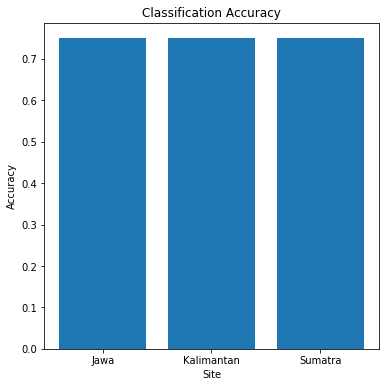

In [96]:
# Classification accuracy dari ketiga pulau 
#print((TP + TN) / float(TP + TN + FP + FN))
print("Classification accuracy Pulau Jawa:",metrics.accuracy_score(Y_test1, y_pred_class1))

#print((TP1 + TN1) / float(TP1 + TN1 + FP1 + FN1))
print("Classification accuracy Pulau Kalimantan:",metrics.accuracy_score(Y_test2, y_pred_class2))

#print((TP2 + TN2) / float(TP2 + TN2 + FP2 + FN2))
print("Classification accuracy Pulau Sumatra:",metrics.accuracy_score(Y_test3, y_pred_class3))

import matplotlib.pyplot as plt

data = {'Jawa': metrics.accuracy_score(Y_test1, y_pred_class1), 'Kalimantan': metrics.accuracy_score(Y_test2, y_pred_class2), 'Sumatra': metrics.accuracy_score(Y_test3, y_pred_class3)}
names = list(data.keys())
values = list(data.values())

fig, axs = plt.subplots(1, 1, figsize=(6, 6), sharey=True)
axs.bar(names, values)

plt.title('Classification Accuracy')
plt.xlabel('Site')
plt.ylabel('Accuracy')

In [97]:
classification_error = (FP + FN) / float(TP + TN + FP + FN)
#print(classification_error)
#print(1 - metrics.accuracy_score(test_y, y_pred_class))
print("Classification error Pulau Jawa:",1 - metrics.accuracy_score(Y_test1, y_pred_class1))

classification_error1 = (FP1 + FN1) / float(TP1 + TN1 + FP1 + FN1)
#print(classification_error1)
print("Classification error Pulau Kalimantan:",1 - metrics.accuracy_score(Y_test2, y_pred_class2))

classification_error = (FP2 + FN2) / float(TP2 + TN2 + FP2 + FN2)
#print(classification_error)
print("Classification error Pulau Sumatra:",1 - metrics.accuracy_score(Y_test3, y_pred_class3))

Classification error Pulau Jawa: 0.25
Classification error Pulau Kalimantan: 0.25
Classification error Pulau Sumatra: 0.25


Recall Rate Sawah Pulau Jawa: 0.5
Recall Rate Sawah Pulau Kalimantan: 0.5
Recall Rate Sawah Pulau Sumatra: 0.5


Text(0.5, 0, 'Site')

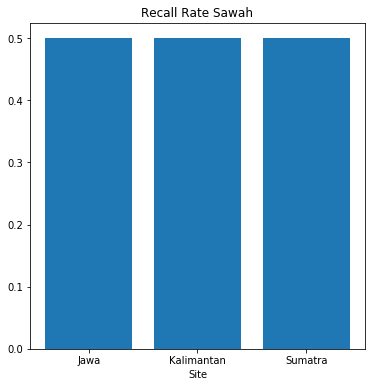

In [98]:
recall_rate_sawah = TP / float(FN + TP)

print("Recall Rate Sawah Pulau Jawa:",recall_rate_sawah)
#print(metrics.recall_score(test_y, y_pred_class))

recall_rate_sawah1 = TP1 / float(FN1 + TP1)

print("Recall Rate Sawah Pulau Kalimantan:",recall_rate_sawah1)
#print(metrics.recall_score(test_y1, y_pred_class1))

recall_rate_sawah2 = TP2 / float(FN2 + TP2)

print("Recall Rate Sawah Pulau Sumatra:",recall_rate_sawah2)
#print(metrics.recall_score(test_y2, y_pred_class2))

import matplotlib.pyplot as plt
import decimal

data = {'Jawa': recall_rate_sawah, 'Kalimantan': recall_rate_sawah1, 'Sumatra': recall_rate_sawah2}
names = list(data.keys())
values = list(data.values())

fig, ax = plt.subplots(1, 1, figsize=(6, 6), sharey=True)
ax.bar(names, values)

plt.title('Recall Rate Sawah')
plt.xlabel('Site')

Recall Rate Bukan Sawah Pulau Jawa: 1.0
Recall Rate Bukan Sawah Pulau Kalimantan: 1.0
Recall Rate Bukan Sawah Pulau Sumatra: 1.0


Text(0, 0.5, 'Recall Rate')

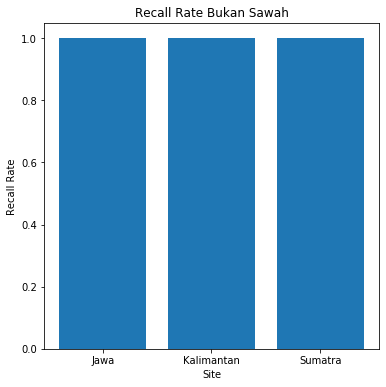

In [99]:
recall_rate_bukan_sawah = TN / (TN + FP)
print("Recall Rate Bukan Sawah Pulau Jawa:",recall_rate_bukan_sawah)

recall_rate_bukan_sawah1 = TN1 / (TN1 + FP1)
print("Recall Rate Bukan Sawah Pulau Kalimantan:",recall_rate_bukan_sawah1)

recall_rate_bukan_sawah2 = TN2 / (TN2 + FP2)
print("Recall Rate Bukan Sawah Pulau Sumatra:",recall_rate_bukan_sawah2)

import matplotlib.pyplot as plt
import decimal

data = {'Jawa': recall_rate_bukan_sawah, 'Kalimantan': recall_rate_bukan_sawah1, 'Sumatra': recall_rate_bukan_sawah2}
names = list(data.keys())
values = list(data.values())

fig, ax = plt.subplots(1, 1, figsize=(6, 6), sharey=True)
ax.bar(names, values)

plt.title('Recall Rate Bukan Sawah')
plt.xlabel('Site')
plt.ylabel('Recall Rate')

In [100]:
false_positive_rate = FP / float(TN + FP)
#print(false_positive_rate)
print("false positive rate Pulau Jawa:",1 - recall_rate_bukan_sawah)

false_positive_rate1 = FP1 / float(TN1 + FP1)
#print(false_positive_rate1)
print("false positive rate Pulau Kalimantan:",1 - recall_rate_bukan_sawah1)

false_positive_rate2 = FP2 / float(TN2 + FP2)
#print(false_positive_rate2)
print("false positive rate Pulau Sumatra:",1 - recall_rate_bukan_sawah2)

false positive rate Pulau Jawa: 0.0
false positive rate Pulau Kalimantan: 0.0
false positive rate Pulau Sumatra: 0.0


Precision Sawah Pulau Jawa: 1.0
Precision Sawah Pulau Kalimantan: 1.0
Precision Sawah Pulau Sumatra: 1.0


Text(0, 0.5, 'Precision')

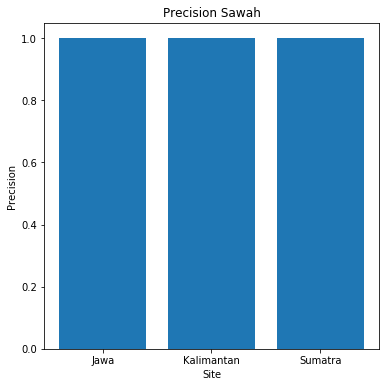

In [101]:
precision_sawah = TP / float(TP + FP)
print("Precision Sawah Pulau Jawa:",precision_sawah)

precision_sawah1 = TP1 / float(TP1 + FP1)
print("Precision Sawah Pulau Kalimantan:",precision_sawah1)

precision_sawah2 = TP2 / float(TP2 + FP2)
print("Precision Sawah Pulau Sumatra:",precision_sawah2)

import matplotlib.pyplot as plt
import decimal

data = {'Jawa': precision_sawah, 'Kalimantan': precision_sawah1, 'Sumatra': precision_sawah2}
names = list(data.keys())
values = list(data.values())

fig, ax = plt.subplots(1, 1, figsize=(6, 6), sharey=True)
ax.bar(names, values)

plt.title('Precision Sawah')
plt.xlabel('Site')
plt.ylabel('Precision')

Precision Bukan Sawah Pulau Jawa: 1.0
Precision Bukan Sawah Pulau Kalimantan: 1.0
Precision Bukan Sawah Pulau Sumatra: 1.0


Text(0, 0.5, 'Precision')

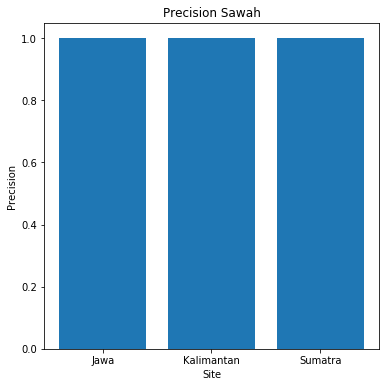

In [102]:
precision_bukan_sawah = TN / float (FP + TN)
print("Precision Bukan Sawah Pulau Jawa:",precision_bukan_sawah)

precision_bukan_sawah1 = TN1 / float(FP1 + TN1)
print("Precision Bukan Sawah Pulau Kalimantan:",precision_bukan_sawah1)

precision_bukan_sawah2 = TN2 / float(FP2 + TN2)
print("Precision Bukan Sawah Pulau Sumatra:",precision_bukan_sawah2)

import matplotlib.pyplot as plt
import decimal

data = {'Jawa': precision_bukan_sawah, 'Kalimantan': precision_bukan_sawah1, 'Sumatra': precision_bukan_sawah2}
names = list(data.keys())
values = list(data.values())

fig, ax = plt.subplots(1, 1, figsize=(6, 6), sharey=True)
ax.bar(names, values)

plt.title('Precision Sawah')
plt.xlabel('Site')
plt.ylabel('Precision')

F1 Sawah Pulau Jawa: 0.6666666666666666
F1 Sawah Pulau Kalimantan: 0.6666666666666666
F1 Sawah Pulau Sumatra: 0.6666666666666666


Text(0, 0.5, 'F1')

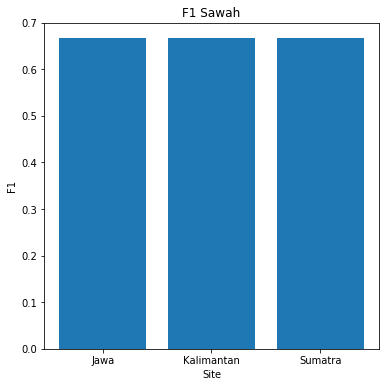

In [103]:
F1_sawah = (2*(precision_sawah*recall_rate_sawah)/(precision_sawah + recall_rate_sawah))
print("F1 Sawah Pulau Jawa:",F1_sawah)

F1_sawah1 = (2*(precision_sawah1*recall_rate_sawah1)/(precision_sawah1 + recall_rate_sawah1))
print("F1 Sawah Pulau Kalimantan:",F1_sawah1)

F1_sawah2 = (2*(precision_sawah2*recall_rate_sawah2)/(precision_sawah2 + recall_rate_sawah2))
print("F1 Sawah Pulau Sumatra:",F1_sawah2)

import matplotlib.pyplot as plt
import decimal

data = {'Jawa': F1_sawah, 'Kalimantan': F1_sawah1, 'Sumatra': F1_sawah2}
names = list(data.keys())
values = list(data.values())

fig, ax = plt.subplots(1, 1, figsize=(6, 6), sharey=True)
ax.bar(names, values)

plt.title('F1 Sawah')
plt.xlabel('Site')
plt.ylabel('F1')

F1 Bukan Sawah Pulau Jawa: 1.0
F1 Bukan Sawah Pulau Kalimantan: 1.0
F1 Bukan Sawah Pulau Sumatra: 1.0


Text(0, 0.5, 'F1')

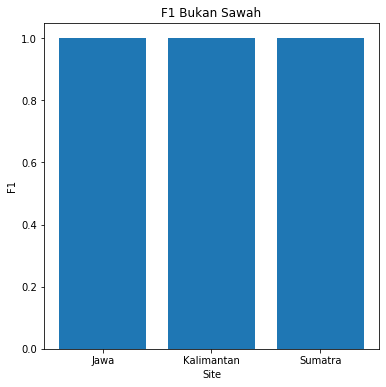

In [104]:
F1_bukan_sawah = (2*(precision_bukan_sawah*recall_rate_bukan_sawah)/(precision_bukan_sawah + recall_rate_bukan_sawah))
print("F1 Bukan Sawah Pulau Jawa:",F1_bukan_sawah)

F1_bukan_sawah1 = (2*(precision_bukan_sawah1*recall_rate_bukan_sawah1)/(precision_bukan_sawah1 + recall_rate_bukan_sawah1))
print("F1 Bukan Sawah Pulau Kalimantan:",F1_bukan_sawah1)

F1_bukan_sawah2 = (2*(precision_bukan_sawah2*recall_rate_bukan_sawah2)/(precision_bukan_sawah2 + recall_rate_bukan_sawah2))
print("F1 Bukan Sawah Pulau Sumatra:",F1_bukan_sawah2)

import matplotlib.pyplot as plt
import decimal

data = {'Jawa': F1_bukan_sawah, 'Kalimantan': F1_bukan_sawah1, 'Sumatra': F1_bukan_sawah2}
names = list(data.keys())
values = list(data.values())

fig, ax = plt.subplots(1, 1, figsize=(6, 6), sharey=True)
ax.bar(names, values)

plt.title('F1 Bukan Sawah')
plt.xlabel('Site')
plt.ylabel('F1')

# Evaluasi Gambar Pelatihan dengan Gambar Data Pengujian

# Mengetahui Akurasi Gambar Data Pengujian dalam Piksel

Pada evaluasi gambar ini, kita mencari akurasi data pengujian dalam piksel. Terdapat 2 jenis gambar yang akan diujikan dalam mendapatkan nilai akurasi piksel, yaitu gambar dengan sawah dan gambar bukan/atau selain sawah.

**Akurasi Gambar Pengujian dengan Sawah**

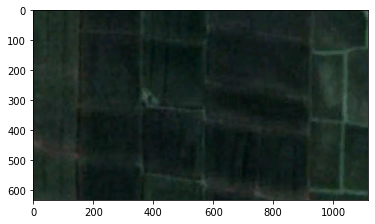

27
1296 27 48


In [105]:

#Membaca Gambar Test Data dan Menampilkannya
img_path = "data/paddy/test/Jawa/b151.jpg"
img = load_img(img_path)
img = img_to_array(img)/255
plt.imshow(img)
plt.show()

#Membuat subimages dengan patches menggunkan metode sliding windows
patches = []
windows = sw.generate(img, sw.DimOrder.HeightWidthChannel, 56, 0.6)
for i,window in enumerate(windows):
    _img = img[window.indices()]
    patches.append(_img)
patches = np.array(patches)

#Mengecek total gambar dan banyaknya gambar yang terpasang pada height direction, maupun width direction
n_total = len(windows)
_x = 0
for i,window in enumerate(windows):
    if _x != window.x:
        n_x = i
        print(n_x)
        break
    _x = window.x


print(n_total,n_x,n_total//n_x)

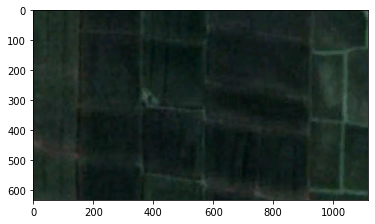

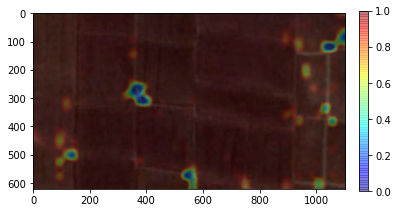

In [106]:
#Memprediksi probalititas keberadaaan lahan sawah padi terhadap gambar yang telah dicacah 
#dan kembali pada gambar original
predictions = model.predict(patches)
#print(predictions.shape)
#print(predictions)
paddy = np.reshape(predictions,(n_total//n_x,n_x))
paddy = np.rot90(paddy)
paddy = np.flip(paddy,axis=0)
#Array pada gambar diperbesar menggunakan interpolasi spline
h_factor = img.shape[0]//paddy.shape[0]
w_factor = img.shape[1]//paddy.shape[1]
#print(h_factor)

from scipy.ndimage import zoom
zoomed = zoom(paddy,(h_factor,w_factor))
#print(zoomed.shape)

#Menampilkan hasil gambar level tertentu
plt.imshow(img)
plt.show()

plt.imshow(img)
plt.imshow(zoomed,alpha=0.3,vmax=1.0,vmin=0,cmap="jet")

plt.colorbar(fraction=0.027, pad=0.04,alpha=0)
plt.show()

In [107]:
#Memperoleh Nilai Akurasi data pengujian dalam piksel
print("Minimal level zoomed :", np.min(zoomed))
print("Maximal level zoomed :", np.max(zoomed))
#Menampilkan nilai level zoomed dalam range 0 sampai 1
normalized = (zoomed-np.min(zoomed))/(np.max(zoomed)-np.min(zoomed))
print("Minimal level ternomalisasi:", np.min(normalized))
print("Maximal level ternomalisasi:", np.max(normalized))
print('')
#Menghitung banyaknya piksel
#Tingkatan level warna dari 0 sampai 1 yang mencapai bentuk sawah adalah 0.5 (Nilai diantara 0 dan 1)
banyakpiksel=(normalized>0.5).sum()
akurasi=((normalized>0.5).sum()*100/(normalized<1).sum())
print("Banyaknya piksel yang terlihat sawah :", (banyakpiksel))
print("Akurasi dalam piksel (100%) :", (akurasi))

Minimal level zoomed : -0.13607986
Maximal level zoomed : 1.1358511
Minimal level ternomalisasi: 0.0
Maximal level ternomalisasi: 1.0

Banyaknya piksel yang terlihat sawah : 675922
Akurasi dalam piksel (100%) : 98.59083437016379


**Akurasi Gambar Pengujian dengan Bukan/Atau Selain Sawah**

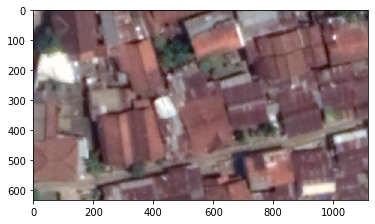

27
1296 27 48


In [108]:
#Membaca Gambar Test Data dan Menampilkannya
img_path11 = "data/paddy/test/Jawa/o153.jpg"
img11 = load_img(img_path11)
img11 = img_to_array(img11)/255
plt.imshow(img11)
plt.show()

#Membuat subimages dengan patches menggunkan metode sliding windows
patches11 = []
windows11 = sw.generate(img11, sw.DimOrder.HeightWidthChannel, 56, 0.6)
for i,window in enumerate(windows11):
    _img11 = img11[window.indices()]
    patches11.append(_img11)
patches11 = np.array(patches11)

#Mengecek total gambar dan banyaknya gambar yang terpasang pada height direction, maupun width direction
n_total11 = len(windows11)
_x11 = 0
for i,window in enumerate(windows11):
    if _x != window.x:
        n_x11 = i
        print(n_x11)
        break
    _x = window.x


print(n_total11,n_x11,n_total11//n_x11)

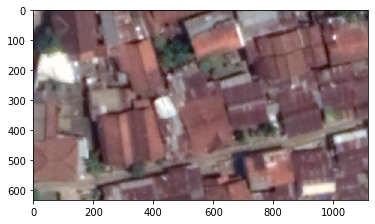

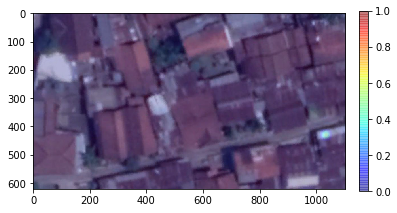

In [109]:
#Memprediksi probalititas keberadaaan lahan sawah padi terhadap gambar yang telah dicacah 
#dan kembali pada gambar original
predictions11 = model.predict(patches11)
#print(predictions.shape)
#print(predictions)
paddy11 = np.reshape(predictions11,(n_total11//n_x11,n_x11))
paddy11 = np.rot90(paddy11)
paddy11 = np.flip(paddy11,axis=0)
#Array pada gambar diperbesar menggunakan interpolasi spline
h_factor11 = img11.shape[0]//paddy11.shape[0]
w_factor11 = img11.shape[1]//paddy11.shape[1]
#print(h_factor)

from scipy.ndimage import zoom
zoomed11 = zoom(paddy11,(h_factor11,w_factor11))
#print(zoomed.shape)

#Menampilkan hasil gambar level tertentu
plt.imshow(img11)
plt.show()

plt.imshow(img11)
plt.imshow(zoomed11,alpha=0.3,vmax=1.0,vmin=0,cmap="jet")

plt.colorbar(fraction=0.027, pad=0.04,alpha=0)
plt.show()

In [110]:
#Memperoleh Nilai Akurasi data pengujian dalam piksel
print("Minimal level zoomed :", np.min(zoomed11))
print("Maximal level zoomed :", np.max(zoomed11))
#Menampilkan nilai level zoomed dalam range 0 sampai 1
normalized11 = (zoomed11-np.min(zoomed11))/(np.max(zoomed11)-np.min(zoomed11))
print("Minimal level ternomalisasi:", np.min(normalized11))
print("Maximal level ternomalisasi:", np.max(normalized11))
print('')
#Menghitung banyaknya piksel
#Tingkatan level warna dari 0 sampai 1 yang mencapai bentuk sawah adalah 0.5 (Nilai diantara 0 dan 1)
banyakpiksel11=(normalized11<0.5).sum()
akurasi11=((normalized11<0.5).sum()*100/(normalized11<1).sum())
print("Banyaknya piksel yang terlihat bukan sawah :", (banyakpiksel11))
print("Akurasi dalam piksel (100%) :", (akurasi11))

Minimal level zoomed : -0.063353725
Maximal level zoomed : 0.46347654
Minimal level ternomalisasi: 0.0
Maximal level ternomalisasi: 1.0

Banyaknya piksel yang terlihat bukan sawah : 684866
Akurasi dalam piksel (100%) : 99.89541747680441


# Evaluasi Data Pelatihan terhadap Pengujian dalam Luas Lahan

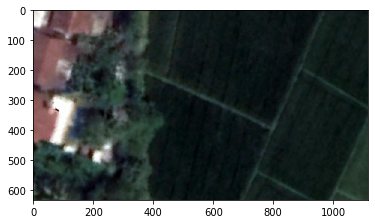

27
1296 27 48


In [111]:
#Membaca Gambar Test Data dan Menampilkannya
img_path22 = "data/paddy/test/test_image/test_image1.jpg"
img22 = load_img(img_path22)
img22 = img_to_array(img22)/255
plt.imshow(img22)
plt.show()

#Membuat subimages dengan patches menggunkan metode sliding windows
patches22 = []
windows22 = sw.generate(img22, sw.DimOrder.HeightWidthChannel, 56, 0.6)
for i,window in enumerate(windows22):
    _img22 = img22[window.indices()]
    patches22.append(_img22)
patches22 = np.array(patches22)

#Mengecek total gambar dan banyaknya gambar yang terpasang pada height direction, maupun width direction
n_total22 = len(windows22)
_x = 0
for i,window in enumerate(windows22):
    if _x != window.x:
        n_x22 = i
        print(n_x22)
        break
    _x = window.x


print(n_total22,n_x22,n_total22//n_x22)

In [112]:
print(patches.shape)

(1296, 56, 56, 3)


#Prediksi Gambar Individual

(1296, 1)
[[2.9802322e-07]
 [0.0000000e+00]
 [0.0000000e+00]
 ...
 [9.9987388e-01]
 [9.9420941e-01]
 [9.9052536e-01]]


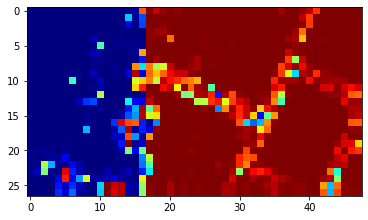

In [113]:
#Memprediksi probalititas keberadaaan lahan sawah padi terhadap gambar yang telah dicacah 
#dan kembali pada gambar original
predictions22 = model.predict(patches22)
print(predictions22.shape)
print(predictions22)

paddy22 = np.reshape(predictions22,(n_total22//n_x22,n_x22))
paddy22 = np.rot90(paddy22)
paddy22 = np.flip(paddy22,axis=0)
plt.imshow(paddy22,cmap="jet")

**Catatan** :
Bahwa setiap gambar sesuai dengan 1 piksel dari probabilitasnya, dan ukurannya tidak kompatibel dengan gambar input.
Oleh karena itu peneliti akan menghitung faktor rasio dan mengubah ukurannya

In [114]:
#Array pada gambar diperbesar menggunakan interpolasi spline
h_factor22 = img22.shape[0]//paddy22.shape[0]
w_factor22 = img22.shape[1]//paddy22.shape[1]
print(h_factor22)

from scipy.ndimage import zoom
zoomed22 = zoom(paddy22,(h_factor22,w_factor22))

print(zoomed22.shape)

23
(621, 1104)


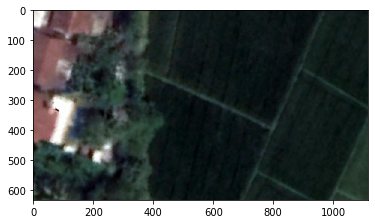

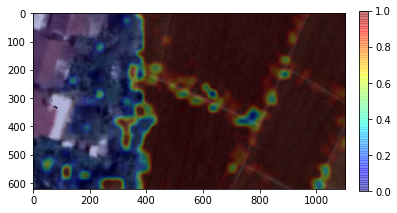

In [115]:
#Menampilkan hasil gambar level tertentu
plt.imshow(img22)
plt.show()

plt.imshow(img22)
plt.imshow(zoomed22,alpha=0.3,vmax=1.0,vmin=0,cmap="jet")

plt.colorbar(fraction=0.027, pad=0.04,alpha=0)
plt.show()

#Menampilkan Luas Lahan Sawah yang berwarna Merah


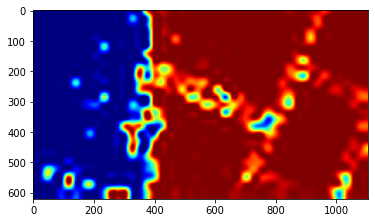

In [121]:
plt.imshow(zoomed22,alpha=1,vmax=1.0,vmin=0,cmap="jet")

#Menghitung luas Sawah 


In [122]:
#Menampilkan nilai level zoomed dalam range acak
print("Minimal level zoomed :", np.min(zoomed22))
print("Maximal level zoomed :", np.max(zoomed22))

Minimal level zoomed : -0.24136063
Maximal level zoomed : 1.1518493


In [123]:
#Menampilkan nilai level zoomed dalam range 0 sampai 1
normalized22 = (zoomed22-np.min(zoomed22))/(np.max(zoomed22)-np.min(zoomed22))
print("Minimal level ternomalisasi:", np.min(normalized22))
print("Maximal level ternomalisasi:", np.max(normalized22))

Minimal level ternomalisasi: 0.0
Maximal level ternomalisasi: 1.0


In [124]:
#Menghitung luas lahan sawah dalam piksel
#Tingkatan level warna dari 0 sampai 1 yang mencapai bentuk sawah adalah 0.5 (Nilai diantara 0 dan 1)
luaspiksel22=(normalized22>0.5).sum()
akurasi22=((normalized22>0.5).sum()*100/(normalized22<1).sum())
print("Luas lahan sawah dalam piksel :", (luaspiksel22))
print("Persentase lahan sawah dalam piksel (100%) :", (akurasi22))

Luas lahan sawah dalam piksel : 453301
Persentase lahan sawah dalam piksel (100%) : 66.11905487738173


"Validitas Pengukuran di Lapangan"

![image](https://raw.githubusercontent.com/Gio1709/paddy_100m/master/Validitas%20Pengukuran.jpg)

Untuk validasi/keakuratan perhitungan konversi nilai piksel pada meter, saya memiliki pengukuran secara langsung di lapangan. Objek yang digunakan sebagai pengukuran tersebut dilakukan pada **lebar jalan di depan rumah**. **Lokasi terletak di Dusun II RT 02/RW 07, Sokaraja Tengah, Kecamatan Sokaraja, Kabupaten Banyumas, Provinsi Jawa Tengah.**

Dengan menggunakan **alat ukur meteran**, diperoleh lebar jalan sebesar **2,71 meter.** Dapat dilihat lebih detail pada gambar.




**"Validasi Nilai Piksel ke dalam Meter"**

![image](https://raw.githubusercontent.com/Gio1709/paddy_100m/master/New%20Gambar%20100m.jpg)

Dapat dilakukan dengan langkah-langkah sbb :
1.   Menzoom/memperbesar sampel gambar (sampai batas maksimum).
2.   Menghitung jumlah piksel, sebagai contoh pada objek lebar jalan. Dimana didapatkan lebarnya sebesar 2,71 meter melalui fitur pengukuran pada Google Earth. Begitu pula dengan validitas pengukuran di lapangan pada lokasi yang sama diperoleh lebar sebesar 2,71 meter.[Resolusi Gambar adalah 1116x632 piksel]
3.   Pada ketinggian 100 meter, dapat dikalkulasi nilai lebar jalan dalam piksel, disini berjumlah 40 piksel. Lalu dilakukan perhitungan sebagai berikut :
    *   Nilai Meter/Piksel(**M/P**) = **M**(meter) / **P**(piksel)
                           = 2,71 meter / 40 piksel
                           = 0,06775 m/p 
                           ~= 0,068 m/p

Maka konversi 1 piksel menjadi meter pada gambar ini sebesar 0,068

Untuk menghitung luas maka dilakukan dengan 0,068 x 0,068 = 0,004624 (m/p)^2

In [125]:
#Setelah diketahui luas sawah dalam piksel, kemudian menkonversi dalam meter dan hektar
#Untuk menghitung luas maka dilakukan dengan 0,3 x 0,3 = 0,09 
luasmtr = 0.004624*(luaspiksel22)
luasha = (luasmtr)/10000
print("Luas lahan sawah dalam meter persegi :", (luasmtr))
print("Luas lahan sawah dalam hektar :", (luasha))

Luas lahan sawah dalam meter persegi : 2096.063824
Luas lahan sawah dalam hektar : 0.20960638239999999


# Perbandingan Hasil Luas Lahan dengan Fitur pada Google Earth

![image](https://raw.githubusercontent.com/Gio1709/paddy_100m/master/Perbandingan%20Google.jpg)

Hasil yang diperoleh pada fitur pengukuran luas lahan dalam hektar pada Google Earth didapatkan hasil sebesar 0,20 Hektar. Akan tetapi perlu diperhatikan dataset pengujian/testing yang digunakan dalam pengukuran lahan sawah mesti pada ketinggian yang sama dengan dataset pelatihan/training. 

Pada bagian ini diketahui ketinggiannya adalah 100 meter.